In [1]:
"""
File: tng_particles.py
Author: Matthew Ogden
Email: ogdenm12@gmail.com
Github: mbogden
Created: 2024-Apr-02

Description: 
    This code is designed to pull particle data from the IllustrisTNG Simulation. 
    It analyzes the particles, reassigned attribution, and performs statistical calculations.
    Designed to use output from tng_find_targets.py.

References:  
- TNG50 Simulation Data
    - Nelson, D. et al. (2015). The Illustris Simulation: Public Data Release. Astronomy and Computing, 13, 12–37. https://doi.org/10.1016/j.ascom.2015.09.003
    - Nelson, D. et al. (2019). First results from the TNG50 simulation: Galactic outflows driven by supernovae and black hole feedback. Monthly Notices of the Royal Astronomical Society, 490(3), 3234–3261. https://doi.org/10.1093/mnras/stz2306
    - Pillepich, A. et al. (2019). First results from the TNG50 simulation: The evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Society, 490(3), 3196–3233. https://doi.org/10.1093/mnras/stz2338

Acknowledgements:    
- Sections of this code were written with the assistance of ChatGPT made by OpenAI.

"""


'\nFile: tng_particles.py\nAuthor: Matthew Ogden\nEmail: ogdenm12@gmail.com\nGithub: mbogden\nCreated: 2024-Apr-02\n\nDescription: \n    This code is designed to pull particle data from the IllustrisTNG Simulation. \n    It analyzes the particles, reassigned attribution, and performs statistical calculations.\n    Designed to use output from tng_find_targets.py.\n\nReferences:  \n- TNG50 Simulation Data\n    - Nelson, D. et al. (2015). The Illustris Simulation: Public Data Release. Astronomy and Computing, 13, 12–37. https://doi.org/10.1016/j.ascom.2015.09.003\n    - Nelson, D. et al. (2019). First results from the TNG50 simulation: Galactic outflows driven by supernovae and black hole feedback. Monthly Notices of the Royal Astronomical Society, 490(3), 3234–3261. https://doi.org/10.1093/mnras/stz2306\n    - Pillepich, A. et al. (2019). First results from the TNG50 simulation: The evolution of stellar and gaseous discs across cosmic time. Monthly Notices of the Royal Astronomical Socie

In [101]:
# ================================ IMPORTS ================================ #
import gc, os, argparse, h5py, pickle, re
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import dask.dataframe as dd


# Illustris TNG import
import illustris_python as il
import tng_functions as tf

print("Imports Done")

# Global variables
SIM_DIR = '/home/tnguser/sims.TNG/TNG50-1/output'

# Am I currently writing this code?
buildEnv = True

Imports Done


In [3]:
# ================================ INPUT ARGUMENTS ================================ #

# Define argument parser function 
def initParser():
    
    parser = argparse.ArgumentParser()
    
    # Simulation Arguments
    parser.add_argument( '-s', '--simDir', default = '/home/tnguser/sims.TNG/TNG50-1/output',  type=str, \
                        help="Base directory for a single simulation on the IllustrisTNG servers.")   
    
    parser.add_argument( '-n', '--simName', default = 'TNG50-1',  type=str, \
                        help="Name for the simulation being worked on.")    

    # Function arguments
    parser.add_argument( '-f', '--function', default = 'None', type=str, \
                        help="Unique functions this program can execute from command line.")
    
    parser.add_argument( '-d', '--dataDir', default = 'data', type=str, \
                        help="Default location to store misc data files.")
    
    parser.add_argument('-ow', '--overwrite', action='store_true',
                        help="Overwrite output files? \
                        If false, will check if output file exists before beginning time-consuming tasks.")
    
    parser.add_argument( '-i', '--inputFile', type=str, \
                        help="Input file location.")
    
    parser.add_argument( '-id', '--targetID', type=int, \
                        help="Misc ID value.  Different between functions.")
    
    parser.add_argument( '-o', '--outputFile', type=str, \
                        help="Output file location.")

    return parser

parser = initParser()
script_args = parser.parse_args()
print("Args: Defined")

Args: Defined


----
# Get Particles and Subhalo Data
Given some inconsistencies within the Subhalo Catalog and it's values, (such as mass for the primary galaxy growing and secondary shrinking before they merged), I suspect how the subhalo algorythm calculates what particles belong to which subhalo is causing an issue. Specifically when two subhalos are close to one another, which tends to happen as they're about to collide.  So I'm going to do my own analysis of the raw particles.  

## Load MOI_4 Data

In [4]:
if buildEnv and True:
    
    m4_loc = 'tng-data/moi_4-test.pkl'
    assert os.path.exists( m4_loc ), f'Target information file not found: {m4_loc}'
    print(f"Reading: {m4_loc}")
    
    # Read potential tng targets file
    m4_df = pd.read_pickle( m4_loc )
    print( f"ALL MOI_4 Shape {m4_df.shape}")
    print( f"Columns: {m4_df.columns}" )
    
    # Pull Data for specific target
    t_id = 62000000190717
    t_snap, t_subhalo = tf.deconstruct_subhalo_id_raw( t_id )
    
    # Get secondary info
    t_row =  m4_df[ m4_df['p_SubhaloIDRaw'] == t_id ]
    
    if len( t_row ) != 1:
        raise ValueError("BAD" )
    t_row = t_row.iloc[0]    
    print("Target Row:")
    print(t_row)
        
    # Save some ids for quick use
    p_id  = t_id
    s_id  = t_row['s_SubhaloIDRaw']
    m2_id = t_row['moi_2']
    
    # Get rows associated with this collision over multiple snapshots
    t_df = m4_df[ m4_df['moi_2'] == m2_id]

    print(f"Target Df: {t_df.shape}")
    

Reading: tng-data/moi_4-test.pkl
ALL MOI_4 Shape (102, 39)
Columns: Index(['moi_2', 'snap', 'merger_snap', 'p_moi_1', 's_moi_1', 'xy_projection',
       'p_face_projection', 's_face_projection', 'p_SubhaloID', 's_SubhaloID',
       'p_NextProgenitorID', 's_NextProgenitorID', 'p_MainLeafProgenitorID',
       's_MainLeafProgenitorID', 'p_FirstProgenitorID', 's_FirstProgenitorID',
       'p_SubhaloGrNr', 's_SubhaloGrNr', 'p_SubhaloIDRaw', 's_SubhaloIDRaw',
       'p_SubhaloMass', 's_SubhaloMass', 'p_RootDescendantID',
       's_RootDescendantID', 'p_SnapNum', 's_SnapNum', 'p_DescendantID',
       's_DescendantID', 'p_SubhaloPos', 's_SubhaloPos', 'p_SubhaloVel',
       's_SubhaloVel', 'p_SubhaloSpin', 's_SubhaloSpin',
       'p_SubhaloHalfmassRad', 's_SubhaloHalfmassRad', 'p_SubhaloCM',
       's_SubhaloCM', 'moi_4'],
      dtype='object')
Target Row:
moi_2                                                        67000000184181
snap                                                            

## Retrieve Subhalo Particles

In [5]:
def get_subhalo_particles(SubhaloIDRaw, get_part='all', basePath=SIM_DIR):
    """
    Load particle data for a given subhalo.  In case of missing particle data, return empty arrays.

    Args:
    SubhaloIDRaw (int): The raw subhalo ID.
    basePath (str): Base path to the simulation data.

    Returns:
    dict: A dictionary containing particle data for 'gas', 'stars', 'dm', and 'bh'.
    """
    def empty_array(fields):
        """ Helper function to create an empty structured array with specified fields. """
        empty_info = {}
        for f in fields:
            
            # Empty x y z array
            if f == 'Coordinates' or f == 'Velocities' or f == 'CenterOfMass':
                empty_info[f] = np.empty((0,3))
            
            # Empty value
            else:                
                empty_info[f] = np.empty(0)
                
        return empty_info

    # Decompose SubhaloIDRaw to get snapshot number and subhalo id
    try:
        if type( SubhaloIDRaw ) == type(pd.Series() ): SubhaloIDRaw = SubhaloIDRaw.values
        snapnum, subhalo_id = tf.deconstruct_subhalo_id_raw(SubhaloIDRaw)
    except:
        print(f"Failed to use SubhaloIDRaw: type: {type(SubhaloIDRaw)} - Value: {SubhaloIDRaw} " )

    tng_part = {}
    
    # What particles am I loading?
    if get_part == 'all':
        particle_types = {
            'gas': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses', ],
            'stars': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses', ],
            'dm': ['Coordinates', 'Velocities', 'ParticleIDs'],
            'bh': ['Coordinates', 'Velocities', 'ParticleIDs', 'BH_Mass']
        }
    elif get_part == 'id':
        particle_types = {
            'gas': ['ParticleIDs'],
            'stars': ['ParticleIDs'],
            'dm': ['ParticleIDs'],
            'bh': ['ParticleIDs']
        }
    elif get_part == 'stars':
        particle_types = {
            'stars': ['Coordinates', 'Velocities', 'ParticleIDs', 'Masses',],
        }
    elif get_part == 'photo':
        particle_types = {
            'stars': ['Coordinates', 'GFM_StellarPhotometrics',],
        }
    else:
        raise AssertionError(f"Expecting 'all', 'stars', 'id', or 'photo' for get_part: {get_part}")
    
    type_to_num = {
        'gas':0,
        'dm':1,
        'stars':4,
        'bh':5,
    }    

    # Attempt to load data for each particle type, handle failures by creating empty arrays
    for ptype, fields in particle_types.items():
        try:
            tng_part[ptype] = il.snapshot.loadSubhalo(basePath, snapnum, subhalo_id, type_to_num[ptype], fields=fields)
        except Exception as e:
            print(f"Failed to load '{ptype}' data for SubhaloID '{SubhaloIDRaw}': \n{e}")
            tng_part[ptype] = empty_array(fields)

    return tng_part

# Dict for going from type str to num and vice versa
pts_type_num = {'gas': 0, 0: 'gas',
                 'dm': 1, 1: 'dm', 
              'stars': 4, 4: 'stars',
                 'bh': 5, 5:'bh',
               }

if buildEnv and True:
    
    print("Requesting Particles")

    tmp_pts_raw = get_subhalo_particles( t_id )
    for k, value in tmp_pts_raw.items():
        # print(f"Pts: {k} \t- {value['count']} \t- {value.keys()} -  " )
        print(f"Pts: {k} \t- {value['count']} \t- {type(value['Coordinates'])} -  " )


Requesting Particles
Pts: gas 	- 2202411 	- <class 'numpy.ndarray'> -  
Pts: stars 	- 1077721 	- <class 'numpy.ndarray'> -  
Pts: dm 	- 3514495 	- <class 'numpy.ndarray'> -  
Pts: bh 	- 1 	- <class 'numpy.ndarray'> -  


In [6]:
def standardize_particles(tng_particles, snap_num, subhaloID=0):
    """
    Standardizes particle data into a large numpy array with meta data.  By default, the illustris_python module 
    returns particles in a dictionary, seperating 'stars', 'gas', 'dark matter', etc.  I want them all together for calculations.

    Inputs:
    - tng_particles (dict): Dictionary containing particle data for different types (e.g., gas, dark matter, stars).
    - snap_num (int): Snapshot number for which the particle data is being standardized.
    - subhaloID (int): Subhalo ID (galaxty) to associate with the particles. Default is 0.

    Outputs:
    - particles (ndarray): Array containing standardized particle data.
                           Columns:
                           0: x-coordinate (kpc/h)
                           1: y-coordinate (kpc/h)
                           2: z-coordinate (kpc/h)
                           3: x-velocity (km/s)
                           4: y-velocity (km/s)
                           5: z-velocity (km/s)
                           6: mass (10^10 M⊙/h)
                           
    - meta (ndarray): Array containing meta data for each particle.
                      Columns:
                      0: particle type (0: gas, 1: dark matter, 4: stars, 5: black hole)
                      1: particle ID (unique identifier for each particle)
                      2: subhalo ID (associated subhalo ID if provided)
    """
    
    # Get mass of dark matter particles from the snapshot header
    dm_part_mass = tf.get_header_info(snap_num, SIM_DIR, 'dark_matter_particle_mass')
    
    # Calculate the total number of particles across all types
    n = sum(tng_particles[k]['Coordinates'].shape[0] for k in tng_particles)
    
    # Initialize containers for particle data and metadata
    particles = np.zeros((n, 7))  # Columns: [x, y, z, vx, vy, vz, mass]
    meta = np.zeros((n, 3), dtype=np.int64)  # Columns: [particle_type, particle_id, subhaloID]
    
    # Index to keep track of the current position in the arrays
    n = 0
    
    # Iterate over each particle type in the dictionary
    for k in tng_particles:
        
        # Get the number of particles of the current type
        m = tng_particles[k]['Coordinates'].shape[0]
        
        ##### Physical Data #####
        # Store the coordinates (kpc/h) for the current particle type
        particles[n:n + m, 0:3] = tng_particles[k]['Coordinates']
        
        # Store the velocities (km/s) for the current particle type
        particles[n:n + m, 3:6] = tng_particles[k]['Velocities']
        
        # Store the mass (10^10 M⊙/h) depending on the particle type
        if k in ['stars', 'gas']:
            particles[n:n + m, 6] = tng_particles[k]['Masses']  # Stars and gas particles have mass data
        elif k == 'bh':
            particles[n:n + m, 6] = tng_particles[k]['BH_Mass']  # Black holes have BH_Mass data
        else:  # Dark matter particles
            particles[n:n + m, 6] = np.full(m, dm_part_mass)  # Use a uniform mass for dark matter particles
        
        ##### META DATA #####
        # Assign particle type based on the current key
        meta[n:n + m, 0] = {'gas': 0, 'dm': 1, 'stars': 4, 'bh': 5}[k]
        
        # Store the particle IDs
        meta[n:n + m, 1] = tng_particles[k]['ParticleIDs']
        
        # If subhaloID is provided, associate it with the particles
        meta[n:n + m, 2] = subhaloID
        
        # Increment the index for the next set of particles
        n += m
    
    # Return the standardized particle data and metadata
    return particles, meta

def std_merger_pts( p_id, s_id, snap ):
    p_raw = get_subhalo_particles( p_id )
    s_raw = get_subhalo_particles( s_id )
    
    p_pts, p_meta = standardize_particles( p_raw, snap, subhaloID=p_id )
    s_pts, s_meta = standardize_particles( s_raw, snap, subhaloID=s_id )
    
    pts  = np.concatenate( ( p_pts,  s_pts  ), axis=0 )
    meta = np.concatenate( ( p_meta, s_meta ), axis=0 )
    
    return pts, meta

if buildEnv and True:
    
    print("Requesting Particles")
    t_pts, t_meta = std_merger_pts( p_id, s_id, t_snap )
    
    print(f"Stardardized Pts: {t_pts.shape} - Meta: {t_meta.shape}")
    print( '\n', t_pts[:2] )
    print( t_meta[:5] )

Requesting Particles
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s'])
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s'])
Stardardized Pts: (7359820, 7) - Meta: (7359820, 3)

 [[ 1.38559854e+04  5.45643945e+03  3.36249844e+04  1.34361496e+02
  -1.55599319e+02 -

In [7]:
def standardize_particles(tng_particles, snap_num):
    """
    Standardizes particle data into a large numpy array with meta data.  By default, the illustris_python module 
    returns particles in a dictionary, seperating 'stars', 'gas', 'dark matter', etc.  I want them all together for calculations.

    Inputs:
    - tng_particles (dict): Dictionary containing particle data for different types (e.g., gas, dark matter, stars).
    - snap_num (int): Snapshot number for which the particle data is being standardized.
    - subhaloID (int): Subhalo ID (galaxty) to associate with the particles. Default is 0.

    Outputs:
    - particles (ndarray): Array containing standardized particle data.
                           Columns:
                           0: x-coordinate (kpc/h)
                           1: y-coordinate (kpc/h)
                           2: z-coordinate (kpc/h)
                           3: x-velocity (km/s)
                           4: y-velocity (km/s)
                           5: z-velocity (km/s)
                           6: mass (10^10 M⊙/h)
                           
    - meta (ndarray): Array containing meta data for each particle.
                      Columns:
                      0: particle type (0: gas, 1: dark matter, 4: stars, 5: black hole)
                      1: particle ID (unique identifier for each particle)
                      2: subhalo ID (associated subhalo ID if provided)
    """
    
    # Get mass of dark matter particles from the snapshot header
    dm_part_mass = tf.get_header_info(snap_num, SIM_DIR, 'dark_matter_particle_mass')
    
    # Calculate the total number of particles across all types
    n = sum(tng_particles[k]['Coordinates'].shape[0] for k in tng_particles)
    
    # Initialize containers for particle data and metadata
    particles = np.zeros((n, 7))  # Columns: [x, y, z, vx, vy, vz, mass]
    pt_type = np.zeros(n, dtype=np.int8)  # particle_type, 
    pt_id = np.zeros(n, dtype=np.int64) # Unique Particle ID
    
    # Index to keep track of the current position in the arrays
    n = 0
    
    # Iterate over each particle type in the dictionary
    for k in tng_particles:
        
        # Get the number of particles of the current type
        m = tng_particles[k]['Coordinates'].shape[0]
        
        ##### Physical Data #####
        # Store the coordinates (kpc/h) for the current particle type
        particles[n:n + m, 0:3] = tng_particles[k]['Coordinates']
        
        # Store the velocities (km/s) for the current particle type
        particles[n:n + m, 3:6] = tng_particles[k]['Velocities']
        
        # Store the mass (10^10 M⊙/h) depending on the particle type
        if k in ['stars', 'gas']:
            particles[n:n + m, 6] = tng_particles[k]['Masses']  # Stars and gas particles have mass data
        elif k == 'bh':
            particles[n:n + m, 6] = tng_particles[k]['BH_Mass']  # Black holes have BH_Mass data
        else:  # Dark matter particles
            particles[n:n + m, 6] = np.full(m, dm_part_mass)  # Use a uniform mass for dark matter particles
        
        ##### META DATA #####
        # Assign particle type based on the current key
        pt_type[n:n + m] = {'gas': 0, 'dm': 1, 'stars': 4, 'bh': 5}[k]
        
        # Store the particle IDs
        pt_id[n:n + m] = tng_particles[k]['ParticleIDs']
        
        # Increment the index for the next set of particles
        n += m
    
    meta = pd.DataFrame( {'particle_type':pt_type,
                          'particle_id':pt_id } )
    
    del pt_type, pt_id
    # gc.collect()
    
    # Return the standardized particle data and metadata
    return particles, meta

def std_merger_pts( p_id, s_id, snap ):
    p_raw = get_subhalo_particles( p_id )
    s_raw = get_subhalo_particles( s_id )
    
    p_pts, p_meta = standardize_particles( p_raw, snap )
    p_meta['subhalo_label'] = np.zeros( p_pts.shape[0], dtype=np.int8)
    s_pts, s_meta = standardize_particles( s_raw, snap )
    s_meta['subhalo_label'] = np.ones( s_pts.shape[0], dtype=np.int8)
    
    pts  = np.concatenate( ( p_pts,  s_pts  ), axis=0 )
    meta = pd.concat( [ p_meta, s_meta ] )
    
    del p_pts, p_meta, s_pts, s_meta
    # gc.collect()
    
    return pts, meta

if buildEnv and True:
    
    print("Requesting Particles")
    t_pts, t_meta = std_merger_pts( p_id, s_id, t_snap )
    
    print(f"Stardardized Pts: {t_pts.shape} - Meta: {t_meta.shape}")
    print( '\n###  Particle Sample  ###', t_pts[:2], '\n' )
    
    print("###  Meta Sample  ###")
    print(t_meta.dtypes)
    print(t_meta.head())
    print(t_meta.tail())

Requesting Particles
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s'])
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s'])
Stardardized Pts: (7359820, 7) - Meta: (7359820, 3)

###  Particle Sample  ### [[ 1.38559854e+04  5.45643945e+03  3.36249844e+04  1.3436149

# Subhalo plots

Let's plot some particles and see how good the subhalo values are as is.

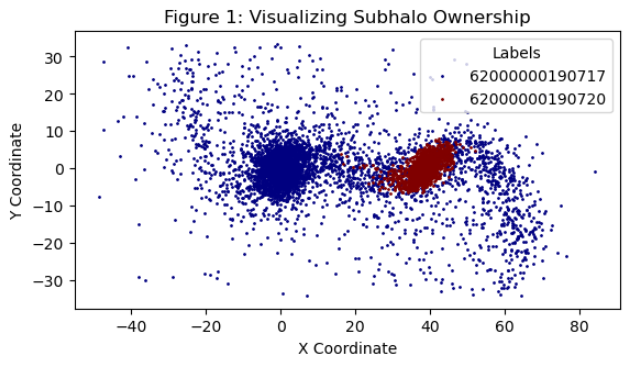

Noting Fig 1 above, many particles that should belong to the secondary galaxy, have instead been attributed to the primary galaxy.  This confirmes my suspicious of particle attribution behaving differently than I wish during mergers.  Thus, the subhalo catalog values for Center of Mass, Total Mass, Spin, HalfMassRadius, etc, aren't going to work for my research.


### Rotational Trasform

Because I'm going to be visuallizing a lot of galaxies, I'd rather have an automated way to standardize the positions of primary and secondary galaxy. My first thought is just to place the two galaxies on the x-axis, then align the spin of the primary so It's pointing in the positive z direction.  Given the primary subhalo seemed to have stolen some of the secondary's outer particles, I'm hoping the primary's spin will do a decent job capturing the overall rotation so we can see it's face.   Here's to hoping!

By the magic of ChatGPT!

[13856.072   5456.5537 33624.73  ] [13886.353  5433.062 33631.49 ] [1583.2437 1453.1172 1875.735 ]
[[ 7.78101444e-01 -6.03657808e-01  1.73653084e-01 -1.33265767e+04]
 [ 5.13872147e-01  4.52757346e-01 -7.28660553e-01  1.49102703e+04]
 [ 3.61238923e-01  6.56207312e-01  6.62494079e-01 -3.08621679e+04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


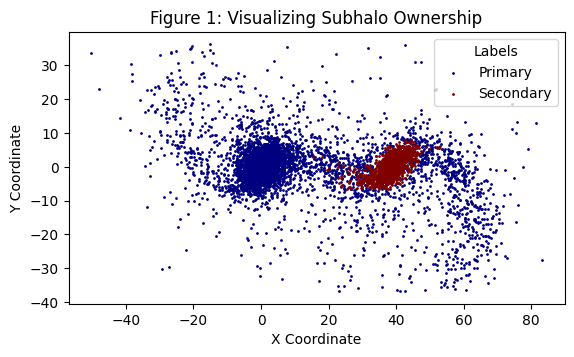

In [8]:
if buildEnv and True:
    
    # Galactic Centers and Spin
    P1 = t_row['p_SubhaloPos']
    P2 = t_row['s_SubhaloPos']
    spin_vector = t_row['p_SubhaloSpin']
    print( P1, P2, spin_vector )
    
    # Points to plots
    star_mask = t_meta['particle_type'].values == pts_type_num['stars']
    plot_pts = t_pts[star_mask]
    labels = np.where( t_meta[star_mask]['subhalo_label'].values, 'Secondary', "Primary" )

    transformation_matrix = tf.calculate_transformation_matrix( P1, P2, spin_vector )
    print(transformation_matrix)
    rot_pts = tf.apply_transformation( transformation_matrix, plot_pts[:,:3] )

    tf.xy_scatter_plot( xy_pts=rot_pts, pt_labels=labels, select_n = 10000, title = 'Figure 1: Visualizing Subhalo Ownership') 

In [9]:
if buildEnv and False:
    
    sig_pts = np.vstack(( t_dict['info']['p_SubhaloCM'], t_dict['info']['s_SubhaloCM'] )) # Add Center of mass positions
    
    vectors = []
    for k in [ 'p', 's' ]:
        cm = t_row[f'{k}_SubhaloCM']
        spin = t_row[f'{k}_SubhaloSpin']
        print( cm, spin )
        vectors.append( np.vstack( ( cm, cm+spin*0.1 ) ) )
    
    vectors = np.array( vectors )
    print(f"vectors: {vectors.shape} ")
        
    tf.interactive_3d_scatter_plot( plot_pts, labels, sig_pts = sig_pts, vector_list = vectors, title = 'Plot of galaxies and Spins around Center of Mass')


-----
# Reassign Particle Ownership via Historic Association 
Now that we've proven that the primary galaxy seems to have "taken" quite a few particles that once belonged to the secondary particles, I'd like to reassign the particles.  But how?  I noticed Particle IDs are given to each particle and according to the data specs, these are a constant value between snapshots in the simulation.  Therefore I suspect I can look backwards in time to see if a particle has been in the primary or secondary galaxy more often.  Then reassign ownership based on which galaxy it has spent more time in.  

## (Deprecated) Get particles over many snapshots.
Turns out, I run out of memory if I try to load all snapshot particles at once.

## Effeciently load particle ID Data
Since we're going to loop over many snapshots, we should make this process as effecient as possible.  Especially since we're liking to load Millions of points across potentially 40 snapshots.  Thus my goal is to only keep 4 columns in memory at any one time.  Let's hope.

In [10]:
def standardize_part_id(tng_particles):
    """
    Standardizes particle IDs.

    Inputs:
    - tng_particles (dict): Dictionary containing particle data for different types (e.g., gas, dark matter, stars).

    Outputs:                           
    - pt_id (ndarray): particle ID (unique identifier for each particle)
    """
    
    # Calculate the total number of particles across all types
    n = sum(tng_particles[k].shape[0] for k in tng_particles) 
    
    # Initialize containers for particle data and metadata
    pt_id = np.zeros(n, dtype=np.int64)  # # particle IDS
    
    # Index to keep track of the current position in the arrays
    i = 0
    
    # Iterate over each particle type in the dictionary
    for k in tng_particles: 
        m = tng_particles[k].shape[0]
        pt_id[i:i + m] = tng_particles[k]
        i += m
    
    # Return the standardized particle data and metadata
    return pt_id


def merger_pt_ids( p_id, s_id ):
    
    # Get particle IDS
    p_raw = get_subhalo_particles( p_id, get_part='id' )
    s_raw = get_subhalo_particles( s_id, get_part='id' )
    
    p_ids = standardize_part_id( p_raw )
    s_ids = standardize_part_id( s_raw )
    t_ids = np.concatenate( ( p_ids, s_ids ) )
    
    p_label = -1 * np.ones(p_ids.shape[0], dtype=np.int8) # -1/Primary
    s_label =      np.ones(s_ids.shape[0], dtype=np.int8)  # 1/Secondary
    labels = np.concatenate( ( p_label, s_label ) )
        
    return t_ids, labels

if buildEnv and True:
    
    pt_ids, labels = merger_pt_ids( p_id, s_id )
    print( f"IDs: {pt_ids.shape} - {labels.shape}")
    print( f"Sample Ids: {pt_ids[:2]} ... {pt_ids[-2:]}" )
    print( f"Sample Label: {labels[:2]} ... {labels[-2:]}" )

IDs: (7359820,) - (7359820,)
Sample Ids: [142993392121 142993408673] ... [  3897592097 111329513164]
Sample Label: [-1 -1] ... [1 1]


---
## Calculating and saving historical affiliation (Sigh)

I have spent a week on this part. Pandas has too much overhead (data somehow quadruples).  Dask keeps erroring and is getting too complicated mitigating those errors.  I'm commiting to two approaches.   

1) Pandas.  This will keep the code straight forward, fast, and will end early if the data takes up too much memory. While the data isn't perfect, it is better than the current particle attribution.  This method will allow me to continue with the next phase of research. 
2) SQLite.  It'll be a lot slower, but it'll make more accurate data and can run in the background over a couple days/weeks.  

In [11]:
# PANDAS Approach
def get_hist_count_pd( args, t_df, mem_limit = 1.2 ):
    
    t_id = t_df.iloc[0]['moi_2']
    merger_snap = t_df.iloc[0]['merger_snap']
    
    start_snap = np.amin( t_df['snap'].values)
    final_snap = merger_snap-1
    
    print(f"Calculating Historical Ownership Count: {t_id}")
    
    # Count file Location
    save_loc = os.path.join(args.dataDir, 'tmp', f'hist-count_{t_id}_pd.h5')
    
    # Check if file exists, return if so
    if not args.overwrite and os.path.exists(save_loc):
        
        tf.tabprint(f"Reading file: {save_loc}")
        
        # Read file and return
        try:
            # Read the data from the HDF5 file and load into a DataFrame
            with h5py.File(save_loc, 'r') as f:
                # Read each dataset
                particleIDs = f['particleIDs'][:]  # Read the 'particleIDs' dataset
                running_count = f['running_count'][:]  # Read the 'running_count' dataset
                count_snap = f['count_snap'][()] # Read final snap the count got to.

            # Create a DataFrame from the loaded data
            count_df = pd.DataFrame({
                'particleIDs': particleIDs,
                'running_count': running_count
            })
            
            del particleIDs, running_count
            return count_df, count_snap
        
        except Exception as e:
            print(f"Failed to read count file due to error: {e}")
            print("Recreating count file")
        
    # Loop through snaps shots and create partquet files for each
    
    count_df = pd.DataFrame({
        'particleIDs': pd.Series(dtype='int64'),   # particleIDs as 64-bit integer
        'running_count': pd.Series(dtype='int8')  # running_count as 8-bit integer
    })
        
    # Calculate the memory usage of the DataFrame in bytes
    mem_gb = 0

    i = 0
    tf.tabprint("i: start/snap/stop (Mem GB) ")
    for snap in range( final_snap, start_snap, -1 ):
    
        tf.tabprint( f'{i}:   {final_snap} / {snap} / {start_snap}  ({mem_gb:.2f} GB)', end='\r' )
        
        # Get info for current snapshot
        tmp_set = t_df[ t_df['snap'] == snap ]
        if not tmp_set.empty:
            row = tmp_set.iloc[0]
        else:
            print(f"\nNo data for snapshot {snap}")
            continue
            
        p_id = row['p_SubhaloIDRaw']
        s_id = row['s_SubhaloIDRaw']

        # Get particles for primary and secondary
        try:
            pt_ids, counts = merger_pt_ids( p_id, s_id )
            
        except Exception as e:
            print(f"\nError loading particles pid/sid: {p_id} / {s_id} \n\t - Error: {e}")
            i+= 1
            continue
        
        tmp_df = pd.DataFrame({
            'particleIDs': pt_ids,
            'running_count':counts,
        })
        del pt_ids, counts  # delete to conserve mem
        gc.collect()
                
        # Merge with previous snapshots
        count_df = pd.concat([count_df, tmp_df])
        gc.collect()
        
        # Calculate the memory usage of the DataFrame in bytes
        mem_gb = count_df.memory_usage(deep=True).sum() / (1024**3)        
        del tmp_df  # conserve memory
        gc.collect()
        
        count_df = count_df.groupby('particleIDs', as_index=False).sum()              
        gc.collect()
        
        if i > 5 and buildEnv: break
        
        i += 1
        
        # End early
        if mem_gb > mem_limit:
            print("\nWARNING:")
            print(f"Count is surpassing RAM limit.  {mem_gb} / {mem_limit} GB")
            print(f"Completed {i} snapshots.  Continue...")
            count_snap = snap
            break
    
    print("\nFinished Creating Count_DF")
    
    with h5py.File( save_loc, 'w') as f:
        f.create_dataset('particleIDs', data=count_df['particleIDs'].values, dtype=np.int64)
        f.create_dataset('running_count', data=count_df['running_count'].values, dtype=np.int8)
        f.create_dataset('count_snap', data=snap)

    return count_df, snap


if buildEnv and False:
    # print(t_df)
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_particles.py'
    cmdStr += ' --dataDir tng-data/'
    # cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])
    
    try:
        count_df, final_snap = get_hist_count_pd( 
            script_args, t_df, mem_limit=0.3 )  
        print(f"Final snap: {final_snap}")
        print(count_df.head())  
        print(count_df.dtypes)  
    except Exception as e:
        print("FAILED")
        print(e)
        pass
    
    print("DONE")    


In [12]:
def add_hist_labels_pd( args, meta_df, t_id, snap ):
    
    save_loc = os.path.join(args.dataDir, 'tmp', 'hist-label_%d-%d_pd.h5' % (t_id, snap))
    
    if not os.path.exists( save_loc ):
        raise AssertionError( f"Hist Label file not found: {save_loc}" )
    
    # Read file
    try:
        # Read the data from the HDF5 file and load into a DataFrame
        with h5py.File(save_loc, 'r') as f:
            # Read each dataset
            pt_id = f['particleIDs'][:]  # Read the 'particleIDs' dataset
            hist_label = f['hist_labels'][:]  # Read the 'running_count' dataset

        # Create a DataFrame from the loaded data
        label_df = pd.DataFrame({
            'particle_id': pt_id,
            'hist_label': hist_label
        })    
        
        # Merge old and new meta df
        meta_df = pd.merge( meta_df, label_df, on='particle_id', how='left' )
        
        # Verify all labels are accounted for
        missing_count = meta_df['hist_label'].isnull().sum()
        if missing_count > 0:
            raise ValueError(f"Missing {missing_count} Labels for snap - target: {snap} - {t_id}")        
    
    except Exception as e:
        print("\n#####   ERRROR   #####\n")
        print(f"{e}")
        raise AssertionError( f"Failed to read file: {save_loc}" )
        
    return meta_df

def create_hist_files_pd( args, t_df, count_df, count_snap, mem_limit = 1.2 ):
    
    save_str = os.path.join(args.dataDir, 'tmp', 'hist-label_%s-%d_pd.h5')
    # print( 'save str: ', save_str )
    
    # Get target info    
    t_id = t_df.iloc[0]['moi_2']
    merger_snap = t_df.iloc[0]['merger_snap']    
    start_snap = merger_snap -  count_snap   
    print(f"Creating Historical Ownership Labels: {t_id}") 
    
    # Check if the final label file exists, if it exists, then the others should be 
    if not args.overwrite:           
        save_loc = save_str%(t_id,count_snap)
        if os.path.exists(save_loc):  
            tf.tabprint("Files already created")
            return
    
    #####  Loop through Snapshots and create labels  #####
    tf.tabprint("i: start/snap/stop (Mem GB) ")
    i = 0
    mem_gb = 0.0
    # Loop through Snapshots and Create historical labels.
    for snap in range( start_snap, count_snap - 1, -1 ):
        
        tf.tabprint( f'{i}:   {start_snap} / {snap} / {count_snap}  ({mem_gb:.2f} GB)', end='\r' )

        # Step 0) Get info for current snapshot
        tmp_set = t_df[ t_df['snap'] == snap ]
        if not tmp_set.empty:
            row = tmp_set.iloc[0]
        else:
            tf.tabprint(f"\nNo data for snapshot {snap}")
            continue
            
        row = t_df[ t_df['snap'] == snap ].iloc[0]
        p_id = row['p_SubhaloIDRaw']
        s_id = row['s_SubhaloIDRaw']

        # Step 1) Load particles for current snapshot
        try:
            pt_ids, counts = merger_pt_ids( p_id, s_id )
            counts *= -1  # For reducing/reversing count
            
        except Exception as e:
            print(f"\nError loading particles pid/sid: {p_id} / {s_id} \n\t - Error: {e}")
            continue
            
        tmp_df = pd.DataFrame({
            'particleIDs': pt_ids,
            'running_count':counts,
        })
        del pt_ids, counts  # delete to conserve mem
        
        # End early
        if tmp_df.memory_usage(deep=True).sum() / (1024**3) > mem_limit:
            print("\nWARNING:")
            print(f"Count is surpassing RAM limit.  {mem_gb} / {mem_limit} GB")
            print(f"Completed {i} snapshots.  Continue...")
            count_snap = snap
            break
                
        # Step 2) Get Subset of count_df and create labels for saving
        label_df = count_df[count_df['particleIDs'].isin(tmp_df['particleIDs'])]
        labels = label_df['running_count'] >= 0 # Negatives(False) for primary
        
        label_loc = save_str % ( t_id, snap ) # Label loc        
        with h5py.File(label_loc, 'w') as f:
            f.create_dataset('particleIDs', data=label_df['particleIDs'].values, dtype=np.int64)
            f.create_dataset('hist_labels', data=labels.values, dtype=np.bool_)
        del labels, label_df
        gc.collect()
                
        # Step 3) Reduce/reverse running count
        count_df = pd.concat( [count_df, tmp_df ] )
        mem_gb = count_df.memory_usage(deep=True).sum() / (1024**3)  # Get mem used
        del tmp_df
        gc.collect()
        
        count_df = count_df.groupby('particleIDs', as_index=False).sum()
        gc.collect()
        
        # Iterate
        i += 1
        # End early
        if mem_gb > mem_limit:
            print("\nWARNING:")
            print(f"Count is surpassing RAM limit.  {mem_gb} / {mem_limit} GB")
            print(f"Completed {i} snapshots.  Continue...")
            count_snap = snap
            break
    # Done

    return count_df

# end create_hist_labels_pd
        
def func_wrapper_create_historical_ownership_pd( args ):
    
    print("Wrapper for Creating Historical Ownership Labels")
    
    # Default location
    moi_loc = args.dataDir + 'moi-3.pkl'
    
    # If specific location given
    if args.inputFile is not None:
        moi_loc = args.inputFile
    
    assert os.path.exists( moi_loc ), f'Target information file not found: {moi_loc}'
    print(f"Reading Target info File: {moi_loc}")
    
    # Read potential tng targets file
    moi_df = pd.read_pickle( moi_loc )
    print( f"ALL Targets Shape {moi_df.shape}")
          
    # Check if specific target was given
    if args.targetID is not None:
        t_id = args.targetID
        moi_df = moi_df[moi_df['moi_2'] == t_id]
        print( f'Single target: {t_id} - {moi_df.shape} ' )
    
    # Loop through moi-2 values for processing
    moi_2_list = moi_df['moi_2'].unique().tolist()
    print(f"Processing {len(moi_2_list)} targets")
    for t_id in moi_2_list:
        
        # Get subset specific to target
        t_df = moi_df[moi_df['moi_2'] == t_id]
        
        # Get count df
        count_df, count_snap = get_hist_count_pd( args, t_df )
        
        # Create labels
        create_hist_files_pd( args, t_df, count_df, count_snap )
        
    # End main loop
        
if buildEnv and False:
    # Command Line Arguments
    cmdStr  = 'python3 tng_particles.py'
    cmdStr += ' --function create_hist_labels_pd'
    cmdStr += ' --dataDir tng-data/'
    cmdStr += ' --inputFile tng-data/moi_4-test.pkl'
    cmdStr += ' --targetID 67000000184181'
    # cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])

if True and script_args.function == 'create_hist_labels_pd':
    func_wrapper_create_historical_ownership_pd( script_args )    


In [13]:


if buildEnv and False:
    
    label_loc = os.path.join('tng-data', 'tmp', 'hist-label_%s-%d_pd.h5'% (m2_id, t_snap) ) 
    print( label_loc )
    
    if not os.path.exists( label_loc ):
        raise ValueError(f"label_loc not found: {label_loc}")
        
    with h5py.File(label_loc, 'r') as f:
        # Read each dataset
        hist_ids = f['particleIDs'][:]
        hist_labels = f['hist_labels'][:]  # Read the 'particleIDs' dataset
                           
    # Create dataframes and merge on ParticleID
    hist_df = pd.DataFrame( {'particle_id':hist_ids, 'hist_label':hist_labels} )
                     
    t_meta = pd.merge( t_meta, hist_df, on='particleIDs', how='left' )
    missing_count = new_df['hist_labels'].isnull().sum()
    
    print(f"Number of missing labels: {missing_count}")
                     
    # Galactic Centers and Spin
    P1 = t_row['p_SubhaloPos']
    P2 = t_row['s_SubhaloPos']
    spin_vector = t_row['p_SubhaloSpin']
    print( P1, P2, spin_vector )
    
    # Points to plots
    star_mask = t_meta[:,0] == pts_type_num['stars']
    plot_pts = t_pts[star_mask]
    old_labels = t_meta[star_mask,2]
    hist_labels = np.where( new_df['hist_labels'].values[star_mask], s_id, p_id )

    transformation_matrix = calculate_transformation_matrix( P1, P2, spin_vector )
    print(transformation_matrix)
    rot_pts = apply_transformation( transformation_matrix, plot_pts[:,:3] )
    
    tf.xy_scatter_plot( xy_pts=rot_pts, pt_labels=old_labels, select_n = 10000, title = 'Figure 3.1: Default Ownership')
    tf.xy_scatter_plot( xy_pts=rot_pts, pt_labels=hist_labels, select_n = 10000, title = 'Figure 3.2: Historical Ownership') 


In [14]:
if buildEnv and False: 
    interactive_3d_scatter( moi_data[snapnum]['data'][star_mask,:][::10], time_labels[star_mask][::10], centers, title = 'Fig 4: Historic Labels')

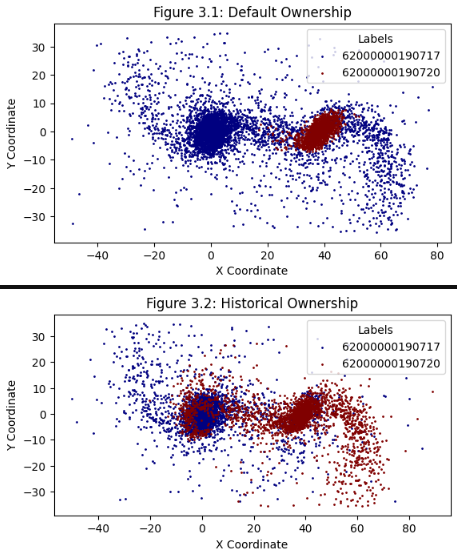

Yay!  Based on Fig 3, I'm much happier with using the historical affiliation to reassign labels. 

In [95]:
import sqlite3
import numpy as np
import os


def create_database(db_location, snapshot_numbers):
    """
    Creates a SQLite database with two tables:
    1. 'historical_count' containing 'particle_id' (int64) and 'running_count' (int8).
       'particle_id' is the primary key.
    2. 'status_table' containing 'snap' (int) and 'status' (BOOLEAN).
       Initializes 'status' to False for all provided 'snapnum' values.

    Parameters:
    - db_location (str): File path where the database will be saved.
    - snapshot_numbers (list or array-like): List of snapshot numbers to initialize in 'status_table'.
    """
    # Ensure snapshot_numbers is a numpy array and convert it to a Python list of integers
    snapshot_numbers = np.asarray(snapshot_numbers, dtype=int).tolist()

    conn = sqlite3.connect(db_location)
    cursor = conn.cursor()
    # Create 'historical_ownership' table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS historical_ownership (
            particle_id INTEGER PRIMARY KEY,
            running_count INTEGER
        )
    ''')
    # Create 'status_table' with 'snapnum' and 'status' columns
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS status_table (
            snapnum INTEGER PRIMARY KEY,
            status BOOLEAN
        )
    ''')
    # Initialize 'status_table' with provided snapshot numbers and status=False
    # Prepare data for insertion
    data = [(int(snapnum), False) for snapnum in snapshot_numbers]
    cursor.executemany('''
        INSERT OR IGNORE INTO status_table (snapnum, status)
        VALUES (?, ?)
    ''', data)
    conn.commit()
    conn.close()


def read_status_table(db_location):
    """
    Reads the 'status_table' and returns all data in two NumPy arrays:
    one for 'snapnum' and one for 'status' values.

    Parameters:
    - db_location (str): File path to the database.

    Returns:
    - snapnums (np.ndarray): Array of snapshot numbers.
    - statuses (np.ndarray): Array of status values (dtype=object to accommodate None).
    """
    conn = sqlite3.connect(db_location)
    cursor = conn.cursor()
    cursor.execute('SELECT snapnum, status FROM status_table')
    results = cursor.fetchall()
    conn.close()

    # Separate results into two lists
    snapnums, statuses = zip(*results) if results else ([], [])
    # Convert to NumPy arrays
    snapnums_array = np.array(snapnums, dtype=int)
    statuses_array = np.array(statuses, dtype=object)  # Use object dtype to include None
    return snapnums_array, statuses_array
    
    
def delete_database(db_location):
    """
    Deletes the entire database file from disk.
    
    Parameters:
    - db_location (str): File path to the database.
    """
    if os.path.exists(db_location):
        os.remove(db_location)


def update_status(db_location, snapnum, status):
    """
    Updates the 'status' for a given 'snapnum' in the 'status_table'.

    Parameters:
    - db_location (str): File path to the database.
    - snapnum (int): The snapshot number to update.
    - status (bool or None): The new status value (True, False, or None).
    """
    # Ensure snapnum is an int
    snapnum = int( snapnum )
    
    # Convert boolean True/False to 1/0 and handle None separately
    if status is True:
        status_value = 1  # SQLite TRUE
    elif status is False:
        status_value = 0  # SQLite FALSE
    else:
        status_value = None  # SQLite NULL
    
    conn = sqlite3.connect(db_location)
    cursor = conn.cursor()
    # Update the status for the given snapnum
    cursor.execute('''
        UPDATE status_table
        SET status = ?
        WHERE snapnum = ?
    ''', (status, snapnum))
    conn.commit()
    conn.close()
    
    
def add_counts_to_db(db_location, particle_ids, counts):
    """
    Adds counts to the database. For each particle ID, it updates the running count
    if it exists or inserts a new row if it doesn't.

    Parameters:
    - db_location (str): File path to the database.
    - particle_ids (np.ndarray): Array of unique particle IDs (int64).
    - counts (np.ndarray): Array of counts (int8) corresponding to the particle IDs.
    """
    # Ensure inputs are numpy arrays
    particle_ids = np.asarray(particle_ids, dtype=np.int64)
    counts = np.asarray(counts, dtype=np.int8)

    conn = sqlite3.connect(db_location)
    cursor = conn.cursor()

    # Prepare data as list of tuples
    data = list(zip(particle_ids.tolist(), counts.tolist()))

    # Use executemany with upsert
    cursor.executemany('''
        INSERT INTO historical_ownership (particle_id, running_count)
        VALUES (?, ?)
        ON CONFLICT(particle_id) DO UPDATE SET running_count = running_count + excluded.running_count
    ''', data)

    conn.commit()
    conn.close()
    
def get_hist_count_sql( args, t_df, save_loc = None ):
    
    t_id = t_df.iloc[0]['moi_2']
    merger_snap = t_df.iloc[0]['merger_snap']
    
    snap_list = t_df['snap'].values
    start_snap = np.amin( snap_list )
    final_snap = merger_snap-1
    
    print(f"\nCalculating Historical Ownership Count: {t_id}")
    # print("#####   USING SMALL SAMPLE OF POINTS   #####")
    
    # Count file Location
    if save_loc is None:
        save_loc = os.path.join(args.dataDir, 'tmp', f'hist-count_{t_id}.db')
    
    # Check if file exists, return if so
    if not args.overwrite and os.path.exists(save_loc):
        tf.tabprint(f"Reading Database: {save_loc}")

    else:
        if os.path.exists( save_loc ):  delete_database( save_loc )        
        tf.tabprint(f"Creating New Database: {save_loc}")
        create_database( save_loc, snap_list )

    # Loop through snaps shots and create partquet files for each    
    snap_sq, snap_status =  read_status_table( save_loc )
    
    for i, snap in enumerate( range( final_snap, start_snap-1, -1 ) ):
            
        # See if data already exists in table
        tmp_i = np.where(snap_sq == snap)[0][0]
        tmp_status = snap_status[tmp_i]
        tf.tabprint( f'{i}:   {final_snap} / {snap} / {start_snap} ({tmp_status})', end='\r' )
        
        # Continue if already accounted for
        if tmp_status != 0:
            continue
        
        # Get info for current snapshot
        tmp_set = t_df[ t_df['snap'] == snap ]
        if not tmp_set.empty:
            row = tmp_set.iloc[0]
        else:
            print(f"\nNo data for snapshot {snap}")
            continue
            
        p_id = row['p_SubhaloIDRaw']
        s_id = row['s_SubhaloIDRaw']
        
        # Get particles for primary and secondary
        try:
            pt_ids, counts = merger_pt_ids( p_id, s_id )
            
            # Sample points while developing code
            # pt_ids = np.hstack( [pt_ids[:100], pt_ids[-100:]] )
            # counts = np.hstack( [counts[:100], counts[-100:]] )

            add_counts_to_db( save_loc, pt_ids, counts )
            update_status( save_loc, snap, True )
            
        except Exception as e:
            print(f"\nError loading particles pid/sid: {p_id} / {s_id} \n\t - Error: {e}")
            update_status( save_loc, snap, None )
            continue
        
        # if i >= 5 and buildEnv: break
    
    tf.tabprint("\nFinished Creating SQL Count")

    # print("File Status:")
    # snap_sq, snap_status =  read_status_table( save_loc )
    # for i in range( len( snap_sq ) ):
    #     print( snap_sq[i], snap_status[i] )
        
    return  
        
if buildEnv and False:    
    print(script_args)
    script_args.overwrite=True    
    get_hist_count_sql( script_args, t_df )

In [112]:
def del_hist_labels_sql( args, t_id ):
    
    hist_dir = os.path.join( args.dataDir, 'tmp', )
    
    # Build the regular expression based on the pattern
    r_str = rf"hist-label_%d-\d+_sql\.h5"%t_id    
    pattern = re.compile(r_str)    
    matching_files = []
    
    # Walk through the directory and subdirectories
    for filename in os.listdir( hist_dir ):
        # Check if the filename matches the regular expression
        if pattern.match(filename):
            # Get the full path to the file and add to the list
            matching_files.append( os.path.join( hist_dir, filename ) )
                
    for file_path in matching_files:   
        try:
            if os.path.exists(file_path):
                os.remove(file_path)
        except Exception as e:
            print(f"Error while deleting file: {e}")

def add_hist_labels_sql( args, meta_df, t_id, snap ):
    label_str = os.path.join(args.dataDir, 'tmp', 'hist-label_%d-%d_sql.h5')
    save_loc = os.path.join(args.dataDir, 'tmp', 'hist-label_%d-%d_sql.h5' % (t_id, snap))
    
    if not os.path.exists( save_loc ):
        raise AssertionError( f"Hist Label file not found: {save_loc}" )
    
    # Read file
    try:
        # Read the data from the HDF5 file and load into a DataFrame
        with h5py.File(save_loc, 'r') as f:
            # Read each dataset
            pt_id = f['particleIDs'][:]  # Read the 'particleIDs' dataset
            hist_label = f['hist_labels'][:]  # Read the 'running_count' dataset

        # Create a DataFrame from the loaded data
        label_df = pd.DataFrame({
            'particle_id': pt_id,
            'hist_label': hist_label
        })    
        
        # Merge old and new meta df
        meta_df = pd.merge( meta_df, label_df, on='particle_id', how='left' )
        
        # Verify all labels are accounted for
        missing_count = meta_df['hist_label'].isnull().sum()
        if missing_count > 0:
            raise ValueError(f"Missing {missing_count} Labels for snap - target: {snap} - {t_id}")        
    
    except Exception as e:
        print("\n#####   ERRROR   #####\n")
        print(f"{e}")
        raise AssertionError( f"Failed to read file: {save_loc}" )
        
    return meta_df

def get_historical_labels(db_location, particle_ids):
    """
    Retrieves historical labels for the given particle IDs based on the running count.
    Label is False if running_count < 0, and True if running_count >= 0.
    
    Parameters:
    - db_location (str): File path to the database.
    - particle_ids (np.ndarray): Array of particle IDs (int64) to retrieve labels for.
    
    Returns:
    - labels (np.ndarray): Array of True/False labels corresponding to the particle IDs.
    """
    particle_ids = np.asarray(particle_ids, dtype=np.int64)
    conn = sqlite3.connect(db_location)
    cursor = conn.cursor()

    # Prepare placeholders for SQL query
    placeholders = ','.join('?' for _ in particle_ids)
    query = f'''
        SELECT particle_id, running_count
        FROM historical_ownership
        WHERE particle_id IN ({placeholders})
    '''
    cursor.execute(query, particle_ids.tolist())
    results = cursor.fetchall()
    conn.close()

    # Map particle_ids to running_counts
    id_to_count = {pid: count for pid, count in results}

    # Create labels array
    labels = np.array([id_to_count.get(pid, 0) >= 0 for pid in particle_ids], dtype=bool)

    return labels


def create_hist_file_sql( args, t_df, db_loc = None, label_str = None ):
    
    t_id = t_df.iloc[0]['moi_2']
    merger_snap = t_df.iloc[0]['merger_snap']
    
    snap_list = t_df['snap'].values
    start_snap = np.amin( snap_list )
    final_snap = merger_snap-1
    
    print(f"\nCreating Historical Ownership Labels: {t_id}")
    # print("#####   USING SMALL SAMPLE OF POINTS   #####")
    
    # Count file Location
    if db_loc is None:
        db_loc = os.path.join(args.dataDir, 'tmp', f'hist-count_{t_id}.db')
        
    if label_str is None:  
        label_str = os.path.join(args.dataDir, 'tmp', 'hist-label_%s-%d_sql.h5')
    
    # Quick Check if the final label file exists. if it exists, others should exist.
    if not args.overwrite:
        label_loc = label_str%(t_id,final_snap)
        if os.path.exists(label_loc):  
            tf.tabprint("Labels already created")
            return
    
    # print("File Status:")
    # snap_sq, snap_status =  read_status_table( db_loc )
    # for i in range( len( snap_sq ) ):
    #     print( snap_sq[i], snap_status[i] )
        
    #####  Loop through Snapshots and create labels  #####
    # Loop through Snapshots and Create historical labels.
    for i, snap in enumerate( range( final_snap, start_snap-1, -1 ) ):
        
        tf.tabprint( f'{i}:   {start_snap} / {snap} / {final_snap}', end='\r' )

        # Step 0) Get info for current snapshot
        tmp_set = t_df[ t_df['snap'] == snap ]
        if not tmp_set.empty:
            row = tmp_set.iloc[0]
        else:
            tf.tabprint(f"\nNo data for snapshot {snap}")
            continue
            
        row = t_df[ t_df['snap'] == snap ].iloc[0]
        p_id = row['p_SubhaloIDRaw']
        s_id = row['s_SubhaloIDRaw']

        # Step 1) Load particles for current snapshot
        try:
            pt_ids, counts = merger_pt_ids( p_id, s_id )
            counts *= -1  # For reducing/reversing count

            # Sample points while developing code
            # pt_ids = np.hstack( [pt_ids[:100], pt_ids[-100:]] )
            # counts = np.hstack( [counts[:100], counts[-100:]] )
            
        except Exception as e:
            print(f"\nError loading particles pid/sid: {p_id} / {s_id} \n\t - Error: {e}")
            update_status( db_loc, snap, None )
            continue
        
        # 2) Query Database to create labels
        labels = get_historical_labels(db_loc, pt_ids)
        assert labels.shape == pt_ids.shape
        # print( labels )

        # 3) Save Labels        
        label_loc = label_str % ( t_id, snap ) # Label loc        
        with h5py.File(label_loc, 'w') as f:
            f.create_dataset('particleIDs', data=pt_ids, dtype=np.int64)
            f.create_dataset('hist_labels', data=labels, dtype=np.bool_)
        
        # 4) Undo count and update status indicating such    
        add_counts_to_db( db_loc, pt_ids, counts )
        update_status( db_loc, snap, False )
              
        # if i > 0: break
    
    tf.tabprint("\nDONE: Creating Hist Labels:")
    # print("File Status:")
    # snap_sq, snap_status =  read_status_table( db_loc )
    # for i in range( len( snap_sq ) ):
    #     print( snap_sq[i], snap_status[i] )
    
    delete_database( db_loc )
            
if buildEnv and True:
    
    script_args.overwrite = False
    del_hist_labels_sql( script_args, m2_id )
    create_hist_file_sql( script_args, t_df )


Creating Historical Ownership Labels: 67000000184181
#####   USING SMALL SAMPLE OF POINTS   #####


OperationalError: no such table: historical_ownership

In [97]:
def func_wrapper_create_historical_ownership_sql( args ):
    
    print("Wrapper for Creating Historical Ownership Labels (SQL)")
    
    # Default location
    moi_loc = args.dataDir + 'moi-3.pkl'
    
    # If specific location given
    if args.inputFile is not None:
        moi_loc = args.inputFile
    
    assert os.path.exists( moi_loc ), f'Target information file not found: {moi_loc}'
    print(f"Reading Target info File: {moi_loc}")
    
    # Read potential tng targets file
    moi_df = pd.read_pickle( moi_loc )
    print( f"ALL Targets Shape {moi_df.shape}")
          
    # Check if specific target was given
    if args.targetID is not None:
        t_id = args.targetID
        moi_df = moi_df[moi_df['moi_2'] == t_id]
        print( f'Single target: {t_id} - {moi_df.shape} ' )
    
    # Loop through moi-2 values for processing
    moi_2_list = moi_df['moi_2'].unique().tolist()
    print(f"Processing {len(moi_2_list)} targets")
    for t_id in moi_2_list:
        
        # Get subset specific to target
        t_df = moi_df[moi_df['moi_2'] == t_id]
        
        # Get count df
        get_hist_count_sql( args, t_df )
        
        # Create labels
        create_hist_file_sql( args, t_df )
        
    # End main loop
        
if buildEnv and True:
    # Command Line Arguments
    cmdStr  = 'python3 tng_particles.py'
    cmdStr += ' --function create_hist_labels_sql'
    cmdStr += ' --dataDir tng-data/'
    cmdStr += ' --inputFile tng-data/moi_4-test.pkl'
    cmdStr += ' --targetID 67000000184181'
    cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])

if True and script_args.function == 'create_hist_labels_sql':
    func_wrapper_create_historical_ownership_sql( script_args )    


CMD Line: 
	$ python3 tng_particles.py --function create_hist_labels_sql --dataDir tng-data/ --inputFile tng-data/moi_4-test.pkl --targetID 67000000184181 --overwrite
Wrapper for Creating Historical Ownership Labels (SQL)
Reading Target info File: tng-data/moi_4-test.pkl
ALL Targets Shape (102, 39)
Single target: 67000000184181 - (26, 39) 
Processing 1 targets

Calculating Historical Ownership Count: 67000000184181
#####   USING SMALL SAMPLE OF POINTS   #####
	 - Creating New Database: tng-data/tmp/hist-count_67000000184181.db
	 - 25:   64 / 39 / 39 (0)
Finished Creating SQL Count

Creating Historical Ownership Labels: 67000000184181
#####   USING SMALL SAMPLE OF POINTS   #####
	 - 25:   39 / 39 / 64
DONE: Creating Hist Labels:


-----
# Comparing Subhalo Catalog to Particle Values

To validate whether my calculated particle dynamics are valid (correct units, methodology, locations, etc) I want to confirm my calculated dynamic values match those of the subhalo catalog.  Then I can get data for the new particles.

## Convenient print function for values
Here's a convenient function to print and compare subhalo catalog values to the values i calculated.

In [16]:
# Write function to verify if calculated values are close to subhalo catalog values
def compare_data( t_row, k ):   
    
    if k[0:3] != '%s_':  k = '%s_' + k
    
    for g in [ 'p', 's' ]:

        print('')
        print( f"{k%g}: {t_row['%s_SubhaloIDRaw'%g]}" )
        
        if isinstance( t_row[k%g], np.ndarray):
            tf.tabprint( f' Original/Calculated (% Diff):' )
            for i in range(t_row[k%g].shape[0]):
                orig_val = t_row[ k % g][i]
                calc_val = t_row[ k % '%sa' % g ][i]
                p_diff = 100 * np.sum(np.abs(orig_val - calc_val)) / np.sum(np.abs(orig_val))
                tf.tabprint( f'{i}: {orig_val:.2e} / {calc_val:.2e} ({p_diff:.2e})' )
                # tabprint( "%% Diff: %.1e" % percent_diff)
            
        else:
            orig_val = t_row[ k % g]
            calc_val = t_row[ k % '%sa' % g ]
            p_diff = 100 * np.sum(np.abs(orig_val - calc_val)) / np.sum(np.abs(orig_val))
            tf.tabprint( f'{orig_val:.2e} / {calc_val:.2e} ({p_diff:.2e})' )
            # tabprint( "%% Diff: %.1e" % percent_diff)

if buildEnv:
# Check values 
        
    sanity_keys = [ '%s_SubhaloPos' ]
    
    for k in sanity_keys:
        for g in [ 'p', 's' ]:
            t_row[ k % '%sa'%g ] = t_row [ k % g ]
            t_row[ k % '%ss'%g ] = t_row [ k % g ]
                
    print( "Postion: SubhaloPos")    
    compare_data( t_row, 'SubhaloPos' )


Postion: SubhaloPos

p_SubhaloPos: 62000000190717
	 -  Original/Calculated (% Diff):
	 - 0: 1.39e+04 / 1.39e+04 (0.00e+00)
	 - 1: 5.46e+03 / 5.46e+03 (0.00e+00)
	 - 2: 3.36e+04 / 3.36e+04 (0.00e+00)

s_SubhaloPos: 62000000190720
	 -  Original/Calculated (% Diff):
	 - 0: 1.39e+04 / 1.39e+04 (0.00e+00)
	 - 1: 5.43e+03 / 5.43e+03 (0.00e+00)
	 - 2: 3.36e+04 / 3.36e+04 (0.00e+00)


-----

## Dynamics Calculation

These following are dynamical values I want from the Subhalo Catalog.   

WARNING:  For some reason the SPIN magnitudes are exponentially off and much bigger than they should be. HOWEVER, as shown later in the orientation function, they do point in the same direction.  While it's frustrating I haven't been able to figure out why, the direction was the critical info I needed and not magnitude. 

In [17]:
# Calculate various dynamic values for group of particles. 

def dynamics_calculation( particles, snapnum ):
    """
    Calculate dynamics-related properties for a group of particles and return them in a dictionary.
    
    WARNING:   For some reason the XYZ Spin components are orders of magnitude off. 
        However, the direction of spin is still correct.

    Parameters:
    - particles (numpy.ndarray): An Nx7 array where each row contains [x, y, z, v_x, v_y, v_z, mass]
    
    Returns:
    - dict: A dictionary containing various dynamics-related properties.
    """
    if particles.shape[1] < 7:
        raise ValueError("Each row in the particles array must contain 7 elements: x, y, z, v_x, v_y, v_z, and mass")

    # Obtain redshift for modifying units
    redshift = tf.get_header_info( snapnum, get_info='redshift' )
    scaling_factor = 1 / (1+redshift)
    
    results = {}

    # Extract mass, positions, and velocities
    positions = particles[:, 0:3]  # ckpc/h 
    velocities = particles[:, 3:6] * np.sqrt(scaling_factor)   # km/s
    masses = particles[:, 6] # 10^10 M_⊙

    # Calculate the total mass
    total_mass = np.sum(masses)
    results['SubhaloMass'] = total_mass

    if total_mass <= 0:
        raise ValueError("Total mass of the particles cannot be zero.")

    # Compute center of mass and velocity
    results['SubhaloCM'] = np.sum(positions * masses[:, None], axis=0) / total_mass
    results['SubhaloVel'] = np.sum(velocities * masses[:, None], axis=0) / total_mass
    
    # Calculate angular momentum (spin)
    r_rel = positions - results['SubhaloCM']  # Relative position vectors
    v_rel = velocities - results['SubhaloVel']  # Relative velocity vectors
    angular_momentum = np.sum( np.cross(r_rel, v_rel) * masses[:, None], axis=0)
    results['SubhaloSpin'] = angular_momentum  # Spin components (x, y, z)

    # Calculate distances from the center of mass and find the half-mass radius
    distances = np.linalg.norm(r_rel, axis=1)
    sorted_indices = np.argsort(distances)
    sorted_masses = masses[sorted_indices]
    cumulative_mass = np.cumsum(sorted_masses)
    half_mass_index = np.searchsorted(cumulative_mass, total_mass / 2)
    results['SubhaloHalfmassRad'] = distances[sorted_indices[half_mass_index]]
        
    return results

if buildEnv:
    
    # Seperate points
    p_mask = t_meta['subhalo_label'] == 0
    p_pts = t_pts[ p_mask ]
    s_pts = t_pts[ ~p_mask ]
    print(f"Prim/Sec Pts: {p_pts.shape} / {s_pts.shape} ")
    
    # Get dynamics of seperate points
    pts = { 'p':p_pts, 's':s_pts }   
    for g in ['p', 's']:
        print(f"Dynamics Calc: {g}")
        new_dyn = dynamics_calculation( pts[g], t_snap )
        for k in new_dyn:            
            new_col = '%sa_%s' % (g, k)
            t_row[new_col] = new_dyn[k]
    print("Finished Dynamics")
    
    print("Comparing Dynamics")    
    for k in new_dyn:
        compare_data( t_row, k )

Prim/Sec Pts: (6794628, 7) / (565192, 7) 
Dynamics Calc: p
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s'])
Dynamics Calc: s
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'MassTable', 'NumFilesPerSnapshot', 'NumPart_ThisFile', 'NumPart_Total', 'NumPart_Total_HighWord', 'Omega0', 'OmegaBaryon', 'OmegaLambda', 'Redshift', 'Time', 'UnitLength_in_cm', 'UnitMass_in_g', 'UnitVelocity_in_cm_per_s'])
Finished Dynamics
Comparing Dynamics

p_SubhaloMass: 62000000190717
	 - 1.26e+02 / 1

---
## Uh oh.  Spins are completely off!

As much as I've tried to troubleshoot this, I can't get the spin's to match those of the catalogs values.  HOWEVER, it just so happens I don't need the exact value.  I just need to make sure the spin direction is correct for my needs. 

In [18]:
def calculate_orientation_angles(spin_vector):
    """
    Calculate the inclination and azimuthal angles from the spin vector.

    Parameters:
    - spin_vector (numpy.ndarray): The angular momentum vector in (kpc/h)(km/s).
    
    Returns:
    - tuple: Inclination angle (degrees), Azimuthal angle (degrees).
    """
    Lx, Ly, Lz = spin_vector
    L_mag = np.linalg.norm(spin_vector)
    
    # Calculate inclination angle
    inclination = np.arccos(Lz / L_mag) if L_mag != 0 else 0
    inclination_deg = np.degrees(inclination)
    
    # Calculate azimuthal angle
    azimuthal = np.arctan2(Ly, Lx)
    azimuthal_deg = np.degrees(azimuthal)
    
    return inclination_deg, azimuthal_deg

# End 
if buildEnv:
    for g in ['p','s']:
        t_row['%s_inclination'%g], t_row['%s_azimuthal'%g] = calculate_orientation_angles( t_row['%s_SubhaloSpin'%g] )
        t_row['%sa_inclination'%g], t_row['%sa_azimuthal'%g] = calculate_orientation_angles( t_row['%sa_SubhaloSpin'%g] )
    for k in ['SubhaloSpin','inclination','azimuthal',]:
        compare_data( t_row, k ) 


p_SubhaloSpin: 62000000190717
	 -  Original/Calculated (% Diff):
	 - 0: 1.58e+03 / 3.25e+05 (2.04e+04)
	 - 1: 1.45e+03 / 2.98e+05 (2.04e+04)
	 - 2: 1.88e+03 / 3.85e+05 (2.04e+04)

s_SubhaloSpin: 62000000190720
	 -  Original/Calculated (% Diff):
	 - 0: 2.52e+01 / 1.70e+02 (5.74e+02)
	 - 1: 1.50e+02 / 1.01e+03 (5.74e+02)
	 - 2: -6.06e+00 / -4.09e+01 (5.74e+02)

p_inclination: 62000000190717
	 - 4.89e+01 / 4.89e+01 (2.17e-06)

s_inclination: 62000000190720
	 - 9.23e+01 / 9.23e+01 (1.42e-05)

p_azimuthal: 62000000190717
	 - 4.25e+01 / 4.25e+01 (4.60e-06)

s_azimuthal: 62000000190720
	 - 8.04e+01 / 8.04e+01 (1.13e-04)


Confirmation the orientation angles match, even if the spins magnitudes are off. 

-----

# Calculate Particle Dynamics on New Particles

## Do dynamic calculations for primary, secondary + stars with new labels.

Now that I'm happy(ish) with my peronsal particle dynamics calculations, let's relabel which subhalo the particles belong to, then do new dynamics calculations on the primary and secondary particles. 

In [114]:

# Calculate particles dynamics based on labels in meta pd.  
def gen_historical_dynamics( args, t_row ):
    """
    Calculate particle dynamics for primary and secondary galaxies 
    based on new historical ownership label.

    Args:
        args (Parser): The input arguments when script was called
        t_row (Series): Series of the target at a snapshot
        label_name (str, optional): The meta column to pull particle ownership for primary or secondary galaxy.

    Returns:
        t_row (Series): The same series with the new info added.
    """
    
    # Create masks for new particle dynamics
    prefix = {'pa': 'All  particles in primary',
              'ps': 'Star particles in primary',
              'sa': 'All  particles in secondary',
              'ss': 'Star particles in secondary',
             }
    
    dyn_fields = ['SubhaloMass',  'SubhaloPos', 'SubhaloCM', \
                  'SubhaloVel', 'SubhaloSpin', 'SubhaloHalfmassRad', \
                  'inclination', 'azimuthal', ]
    
    # Grab a few target values
    pid = t_row['p_SubhaloIDRaw']
    sid = t_row['s_SubhaloIDRaw']
    m2_id = t_row['moi_2']
    snap = t_row['snap']
    
    print(f"\nNew Collision Dynamics for pid/sid: {pid} / {sid} " )
        
    do_new_calc = False    
    # Check if this snapshot is already processed
    for g in prefix:
        for d in dyn_fields:
            tmp_val = t_row.get( '%s_%s' % (g,d) )
            if tmp_val is None:
                do_new_calc = True
    
    if do_new_calc == False and not args.overwrite :
        print(f"New Collision Dynamics already exists: {pid}")
        return t_row

    try:

        # Get particles
        tf.tabprint('Retreiving Particles')
        pts, meta = std_merger_pts( pid, sid, snap )
        
        # Get labels
        tf.tabprint("Getting Hist Labels")
        meta = add_hist_labels_sql( args, meta, m2_id, snap )              

        # Create masks for seperating points 
        tf.tabprint("Creating Particle Masks")  
        p_mask = meta['hist_label'] == False
        star_mask = meta['particle_type'] == 4        
        pt_masks = {
            'pa':  p_mask, # All  particles in primary
            'sa': ~p_mask, # All  particles in secondary
            'ps': np.logical_and(  p_mask, star_mask ), # Star particles in primary
            'ss': np.logical_and( ~p_mask, star_mask ), # Star particles in secondary
        }
        
        # Generate new Dynamic Values
        tf.tabprint("Running Dynamics Calculations")
        
        # Get orientation of subhalo catalog values
        t_row['p_inclination'], t_row['p_azimuthal'] = calculate_orientation_angles( t_row['p_SubhaloSpin'] )
        t_row['s_inclination'], t_row['s_azimuthal'] = calculate_orientation_angles( t_row['s_SubhaloSpin'] )        
        
        # Get new label dynamics calculations
        for m in pt_masks:
            mask = pt_masks[m]    # mask for approapiate particles         
            new_dyn = dynamics_calculation( pts[mask], snap ) # Call func
            
            # Save new values
            for k in new_dyn:
                new_col = '%s_%s' % (m, k)
                t_row[new_col] = new_dyn[k]
            
            # Get inclination and azimuthal
            t_row['%s_inclination'%m], t_row['%s_azimuthal'%m] = calculate_orientation_angles( t_row['%s_SubhaloSpin'%m] )
                
        print("Finished Dynamics")

    except Exception as e:
        print("\n#####   FAILED   #####\n")
        print( e )
        print('')
    
    return t_row


# Takes a while, is done below
if buildEnv and True:
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_particles.py'
    # cmdStr += ' --function create_hist_labels_pd'
    cmdStr += ' --dataDir tng-data/'
    # cmdStr += ' --inputFile tng-data/moi_4-test.pkl'
    # cmdStr += ' --targetID 67000000184181'
    # cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])
    
    #moi_data = calculate_historic_affiliation( moi_data, snapnum )    
    new_row = gen_historical_dynamics( script_args, t_row )
    print('DONE')
    print(new_row)
    
    dyn_fields = ['SubhaloMass',  'SubhaloPos', 'SubhaloCM', \
                  'SubhaloVel', 'SubhaloSpin', 'SubhaloHalfmassRad', \
                  'inclination', 'azimuthal', ]
    
    print("\nDynamic Name  -   Subhalo Catalog Value  -  All Particle Value  -   Star Particle Value\n" )
    for d in dyn_fields:
        for g in ['p','s']:
            tf.tabprint(f"{'%s_%s'%(g,d)} - {t_row['%s_%s' % (g,d) ]}  - {t_row['%sa_%s' % (g,d) ]}  - {t_row['%ss_%s' % (g,d) ]} ")

CMD Line: 
	$ python3 tng_particles.py --dataDir tng-data/

New Collision Dynamics for pid/sid: 62000000190717 / 62000000190720 
New Collision Dynamics already exists: 62000000190717
DONE
moi_2                                                       67000000184181
snap                                                                    62
merger_snap                                                             65
p_moi_1                                                     50000000220008
s_moi_1                                                     50000000220010
                                               ...                        
ss_SubhaloVel            [97.41979882937079, -124.7815502353083, -348.9...
ss_SubhaloSpin           [3125.2883281693807, 5167.053305491889, 144.07...
ss_SubhaloHalfmassRad                                             5.593728
ss_inclination                                                   88.633232
ss_azimuthal                                                  

In [120]:

def func_wrapper_new_target_dynamics( args ):
    
    print("Wrapper for Creating New Dynamic Values for Collision Targets")
    
    # Default location
    moi_loc = args.dataDir + 'moi-3.pkl'
    
    # If specific location given
    if args.inputFile is not None:
        moi_loc = args.inputFile
    
    assert os.path.exists( moi_loc ), f'Target information file not found: {moi_loc}'
    tf.tabprint(f"Reading Target info File: {moi_loc}")
    
    # Read potential tng targets file
    moi_df = pd.read_pickle( moi_loc )
    tf.tabprint( f"ALL Targets Shape {moi_df.shape}")
          
    # Check if specific target was given
    if args.targetID is not None:
        t_id = args.targetID
        moi_df = moi_df[moi_df['moi_2'] == t_id]
        tf.tabprint( f'Single target: {t_id} - {moi_df.shape} ' )
    
    # Load existing dynamics data if it exists
    new_save_loc = moi_loc.replace('.', '-dynamics.')
    if os.path.exists(new_save_loc):
        existing_df = pd.read_pickle(new_save_loc)
        tf.tabprint(f"Existing dynamics file found: {new_save_loc}, shape: {existing_df.shape}")
    else:
        existing_df = pd.DataFrame(columns=['moi_2','snap'])  # Create an empty DataFrame if no file exists
        
        
    # Loop through moi-2 values for processing
    moi_2_list = moi_df['moi_2'].unique().tolist()
    tf.tabprint(f"Processing {len(moi_2_list)} targets")
    
    for t_id in moi_2_list:
        
        # Get subset specific to target
        t_df = moi_df[moi_df['moi_2'] == t_id]
        
        # Get count df
        get_hist_count_sql( args, t_df )
        
        # Create labels
        create_hist_file_sql( args, t_df )
        
        for index, t_row in t_df.iterrows():
            
            # Check if this row already exists in the saved DataFrame
            existing_row = existing_df[
                (existing_df['moi_2'] == t_row['moi_2']) & 
                (existing_df['snap'] == t_row['snap'])
            ]

            # Skip processing if the row already exists
            if not existing_row.empty and not args.overwrite:
                tf.tabprint(f"Skipping already processed row: moi_2 = {t_row['moi_2']}, snap = {t_row['snap']}")
                continue
                
            new_row = gen_historical_dynamics( args, t_row )

            # Append new row to the existing DataFrame
            existing_df = pd.concat([existing_df, pd.DataFrame([new_row])], ignore_index=True)

            # Save the updated DataFrame to avoid losing progress
            existing_df.to_pickle(new_save_loc)
            existing_df.to_csv(new_save_loc.replace('.pkl', '.csv'), index=False)
            gc.collect()
        
        del_hist_labels_sql( args, t_id )
        

    # End main loop

if buildEnv and True:  # Use compiled script from cmd line for speed. 
    
    # Command Line Arguments
    cmdStr  = 'python3 tng_particles.py'
    cmdStr += ' --function new_target_dynamics'
    cmdStr += ' --dataDir tng-data/'
    cmdStr += ' --inputFile tng-data/moi_4-test2.pkl'
    cmdStr += ' --targetID 67000000184181'
    cmdStr += ' --overwrite'
    
    # Read string as if command line
    print( "CMD Line: \n\t$", cmdStr)
    
    # This function doesn't like the 'python3 my-script.py' part.
    script_args = parser.parse_args(cmdStr.split()[2:])
    
if script_args.function == 'new_target_dynamics':
    func_wrapper_new_target_dynamics( script_args )
    print('DONE')

CMD Line: 
	$ python3 tng_particles.py --function new_target_dynamics --dataDir tng-data/ --inputFile tng-data/moi_4-test2.pkl --targetID 67000000184181
Wrapper for Creating New Dynamic Values for Collision Targets
Reading Target info File: tng-data/moi_4-test2.pkl
ALL Targets Shape (102, 39)
Single target: 67000000184181 - (26, 39) 
Processing 1 targets

Calculating Historical Ownership Count: 67000000184181
#####   USING SMALL SAMPLE OF POINTS   #####
	 - Creating New Database: tng-data/tmp/hist-count_67000000184181.db
	 - 25:   64 / 39 / 39 (0)
Finished Creating SQL Count

Creating Historical Ownership Labels: 67000000184181
#####   USING SMALL SAMPLE OF POINTS   #####
	 - Labels already created

New Collision Dynamics for pid/sid: 39000000245339 / 39000000261638 
	 - Retreiving Particles
dict_keys(['BoxSize', 'Composition_vector_length', 'Flag_Cooling', 'Flag_DoublePrecision', 'Flag_Feedback', 'Flag_Metals', 'Flag_Sfr', 'Flag_StellarAge', 'Git_commit', 'Git_date', 'HubbleParam', 'M

KeyboardInterrupt: 